In [1]:
import os
import sys
sys.path.append('/mnt/mnt/5TB_slot2/Tobias')
sys.path.append('/mnt/mnt/5TB_slot2/Tobias/TobiasPy/fastMRI')
sys.path.append('/mnt/mnt/4TB_pcie/fastBrain/')
import h5py
import numpy as np
import numpy.fft as nf
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader
from models.unet.unet_model import UnetModel as UnetModel
from FF_net import FF_net
from FF_net import FF_simple_net
from FF_net import FF_net_tanh
import argparse
from common.args import Args
import models.unet.run_unet  as Run
import torch.nn as nn
import logging
import pathlib
import random
from torch.utils.data import Dataset
import time
from torch.nn import functional as F
import shutil
from tensorboardX import SummaryWriter
import torchvision
from torchvision import transforms, utils
import net_utils as nu
import calendar
import datetime

import sigpy as sp
import sigpy.plot as pl
import vd_spiral

from wrap_net import wrap_net

%load_ext autoreload
%autoreload 2

In [2]:
sys.argv=['']
def create_arg_parser():
    timestamp = calendar.timegm(time.gmtime())
    human_readable = datetime.datetime.fromtimestamp(timestamp).isoformat()
    parser = argparse.ArgumentParser(description="ML parameters")
    parser.add_argument('--num-pools', type=int, default=4, help='Number of U-Net pooling layers')
    parser.add_argument('--drop-prob', type=float, default=0.0, help='Dropout probability')
    parser.add_argument('--num-chans', type=int, default=32, help='Number of U-Net channels')

    parser.add_argument('--batch-size', default=64, type=int, help='Mini batch size')
    parser.add_argument('--num-epochs', type=int, default=3000, help='Number of training epochs')
    parser.add_argument('--lr', type=float, default=0.1, help='Learning rate')
    parser.add_argument('--lr-step-size', type=int, default=100,
                        help='Period of learning rate decay')
    parser.add_argument('--lr-gamma', type=float, default=0.1,
                        help='Multiplicative factor of learning rate decay')
    parser.add_argument('--weight-decay', type=float, default=0.01,
                        help='Strength of weight decay regularization')
    parser.add_argument('--momentum', type=float, default=0.1,
                        help='Strength of optimizer momentum')

    parser.add_argument('--report-interval', type=int, default=10000, help='Period of loss reporting')
    parser.add_argument('--data-parallel', default=True,
                        help='If set, use multiple GPUs using data parallelism')
    parser.add_argument('--device', type=str, default='cuda',
                        help='Which device to train on. Set to "cuda" to use the GPU')
    parser.add_argument('--exp-dir', type=pathlib.Path, default='/mnt/mnt/5TB_slot2/Tobias/Thesis/FF_lrelue_'+str(human_readable),
                        help='Path where model and results should be saved')
    parser.add_argument('--resume', action='store_true', default=False,
                        help='If set, resume the training from a previous model checkpoint. '
                             '"--checkpoint" should be set with this')
    parser.add_argument('--checkpoint', type=str, default='/mnt/mnt/5TB_slot2/Tobias/Thesis/FF_lrelu_'+str(human_readable)+'/best_model.pt',
                        help='Path to an existing checkpoint. Used along with "--resume"')
    parser.add_argument('--logdir', type=str, default='/mnt/mnt/5TB_slot2/Tobias/Thesis/log/ff_lreluu_'+str(human_readable),
                        help='Path to an existing checkpoint. Used along with "--resume"')
    parser.add_argument('--seed', default=42, type=int, help='Seed for random number generators')
    parser.add_argument('--resolution', default=320, type=int, help='Resolution of images')
    parser.add_argument('--device_ids', default=[3] , help='GPUS used')
    return parser
args=create_arg_parser().parse_args()

In [3]:
class SliceData(Dataset):
    """
    A PyTorch Dataset that provides access to MR image slices.
    """
    
    def __init__(self, root="/mnt/mnt/5TB_slot2/fastMRI/multicoil_train", sample_rate=1.):
        self.examples = []
        #potential to apply pre-process transform
        files = list(pathlib.Path(root).iterdir())
        if sample_rate < 1:
            #random.shuffle(files)
            num_files = round(len(files) * sample_rate)
            files = files[:num_files]
        for fname in sorted(files):
            print(fname)
            try:
                #print(h5py.File(fname, 'r').keys())
                #maybe also only randomly select parts of slices. Otherwise lot of outer noise-like structures.
                xml = h5py.File(fname, 'r')['ismrmrd_header']
                kspace = h5py.File(fname, 'r')['kspace']
                num_slices = kspace.shape[0]
                num_channels=kspace.shape[1]
                if (kspace.shape[-2]<args.resolution) or (kspace.shape[-1]<args.resolution):# or num_channels!=16:
                    continue
                print(len(self.examples))
                for slice in range(num_slices):
                    print(slice)
                    crop_size = (min(args.resolution, kspace.shape[-2]),min(args.resolution, kspace.shape[-1]))
                    k=nu.center_crop(kspace[slice], crop_size)
                    #full=to_tensor(np.array([make_ft(rsos(make_ift(k),0)) for i in range(k.shape[0])]))
                    target=np.abs(nu.rsos(nu.make_ift(k),0))
                    target/=np.max(target)
                    full=nu.to_tensor(nu.make_ft(target))
                    full/=np.max(target)
                    for i in range(full.shape[-2]): #phase direction(height)
                        #d=torch.max(full[i])
                        f=full[:,i,:].flatten() #include complex as last dimension
                        t=nu.to_tensor(target[:,i])
                        #print(f.shape)
                        #print(t.shape)
                        self.examples += [(fname, slice, f, t)]
            except:
                print("Couldn't open file")

    def __len__(self):
        return len(self.examples)
    
    def __getitem__(self, i):
        fname, slice, f, t = self.examples[i]
#         with h5py.File(fname, 'r') as data:
#             full=to_tensor(data['kspace'][slice])
#             crop_size = (min(args.resolution, full.shape[-3]),min(args.resolution, full.shape[-2]))          
#             full=complex_center_crop(full,crop_size)
            
#             kspace = to_tensor(data['kspace'][slice])
#             crop_size = (min(args.resolution, kspace.shape[-3]), min(args.resolution, kspace.shape[-2]))
#             kspace=apply_mask(kspace)[0]
#             kspace = complex_center_crop(kspace, crop_size)
            
        return (f, t)

In [4]:
def create_data_loaders():
    #batch_size=32
    #mask_func = None
    #if args.mask_kspace:
    #    mask_func = MaskFunc(args.center_fractions, args.accelerations)
    train_data = SliceData(root="/mnt/mnt/4TB_pcie/fastBrain/multicoil_train",sample_rate=0.5)
    dev_data = SliceData(root="/mnt/mnt/4TB_pcie/fastBrain/multicoil_test_brain",sample_rate=0.5)
    test_data = SliceData(root="/mnt/mnt/4TB_pcie/fastBrain/multicoil_test_brain",sample_rate=0.5)
    train_loader = DataLoader(
        dataset=train_data,
        batch_size=args.batch_size,
        shuffle=True,
        num_workers=0,
        pin_memory=True,
    )
    dev_loader = DataLoader(
        dataset=dev_data,
        batch_size=args.batch_size,
        num_workers=0,
        pin_memory=True,
    )
    test_loader=None
#     test_loader = DataLoader(
#         dataset=test_data,
#         num_workers=0,
#         pin_memory=True,
#     )
    return train_loader, dev_loader, test_loader

In [5]:
t=time.time()
train_loader, dev_loader, test_loader= create_data_loaders()
print("Time taken to load data: ",time.time()-t)

/mnt/mnt/4TB_pcie/fastBrain/multicoil_train/file_brain_AXFLAIR_200_6002428.h5
0
0
1
2
3
4
5
6
7
8
9
10
11
12
13
/mnt/mnt/4TB_pcie/fastBrain/multicoil_train/file_brain_AXFLAIR_200_6002429.h5
4480
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
/mnt/mnt/4TB_pcie/fastBrain/multicoil_train/file_brain_AXFLAIR_200_6002442.h5
9600
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
/mnt/mnt/4TB_pcie/fastBrain/multicoil_train/file_brain_AXFLAIR_200_6002452.h5
14720
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
/mnt/mnt/4TB_pcie/fastBrain/multicoil_train/file_brain_AXFLAIR_200_6002458.h5
19840
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
/mnt/mnt/4TB_pcie/fastBrain/multicoil_train/file_brain_AXFLAIR_200_6002466.h5
24960
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
/mnt/mnt/4TB_pcie/fastBrain/multicoil_train/file_brain_AXFLAIR_200_6002469.h5
30080
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
/mnt/mnt/4TB_pcie/fastBrain/multicoil_train/file_brain_AXFLAIR_200_6002474.h5
35200
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
/mnt/mnt/4TB_pcie/fastBrain/multicoi

6
7
8
9
10
11
12
13
14
15
/mnt/mnt/4TB_pcie/fastBrain/multicoil_train/file_brain_AXFLAIR_202_6000421.h5
/mnt/mnt/4TB_pcie/fastBrain/multicoil_train/file_brain_AXFLAIR_202_6000424.h5
/mnt/mnt/4TB_pcie/fastBrain/multicoil_train/file_brain_AXFLAIR_202_6000428.h5
/mnt/mnt/4TB_pcie/fastBrain/multicoil_train/file_brain_AXFLAIR_202_6000431.h5
/mnt/mnt/4TB_pcie/fastBrain/multicoil_train/file_brain_AXFLAIR_202_6000436.h5
/mnt/mnt/4TB_pcie/fastBrain/multicoil_train/file_brain_AXFLAIR_202_6000437.h5
/mnt/mnt/4TB_pcie/fastBrain/multicoil_train/file_brain_AXFLAIR_202_6000469.h5
/mnt/mnt/4TB_pcie/fastBrain/multicoil_train/file_brain_AXFLAIR_202_6000474.h5
/mnt/mnt/4TB_pcie/fastBrain/multicoil_train/file_brain_AXFLAIR_202_6000477.h5
/mnt/mnt/4TB_pcie/fastBrain/multicoil_train/file_brain_AXFLAIR_202_6000480.h5
/mnt/mnt/4TB_pcie/fastBrain/multicoil_train/file_brain_AXFLAIR_202_6000483.h5
/mnt/mnt/4TB_pcie/fastBrain/multicoil_train/file_brain_AXFLAIR_202_6000489.h5
/mnt/mnt/4TB_pcie/fastBrain/multicoil_

2
3
4
5
6
7
8
9
10
11
12
13
14
15
/mnt/mnt/4TB_pcie/fastBrain/multicoil_train/file_brain_AXT2_200_2000471.h5
490880
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
/mnt/mnt/4TB_pcie/fastBrain/multicoil_train/file_brain_AXT2_200_2000474.h5
496000
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
/mnt/mnt/4TB_pcie/fastBrain/multicoil_train/file_brain_AXT2_200_2000479.h5
501120
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
/mnt/mnt/4TB_pcie/fastBrain/multicoil_train/file_brain_AXT2_200_2000481.h5
506240
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
/mnt/mnt/4TB_pcie/fastBrain/multicoil_train/file_brain_AXT2_200_2000484.h5
511360
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
/mnt/mnt/4TB_pcie/fastBrain/multicoil_train/file_brain_AXT2_200_2000486.h5
516480
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
/mnt/mnt/4TB_pcie/fastBrain/multicoil_train/file_brain_AXT2_200_2000488.h5
521600
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
/mnt/mnt/4TB_pcie/fastBrain/multicoil_train/file_brain_AXT2_200_2000496.h5
526720
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
/mnt/m

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
/mnt/mnt/4TB_pcie/fastBrain/multicoil_train/file_brain_AXT2_200_6002235.h5
843520
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
/mnt/mnt/4TB_pcie/fastBrain/multicoil_train/file_brain_AXT2_200_6002238.h5
848640
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
/mnt/mnt/4TB_pcie/fastBrain/multicoil_train/file_brain_AXT2_200_6002240.h5
853760
0
1
2
3
4
5
6
7
8
9
10
11
12
13
/mnt/mnt/4TB_pcie/fastBrain/multicoil_train/file_brain_AXT2_200_6002242.h5
858240
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
/mnt/mnt/4TB_pcie/fastBrain/multicoil_train/file_brain_AXT2_200_6002246.h5
863360
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
/mnt/mnt/4TB_pcie/fastBrain/multicoil_train/file_brain_AXT2_209_2090155.h5
868480
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
/mnt/mnt/4TB_pcie/fastBrain/multicoil_train/file_brain_AXT2_209_2090156.h5
873600
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
/mnt/mnt/4TB_pcie/fastBrain/multicoil_train/file_brain_AXT2_209_2090159.h5
878720
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
/mnt/mnt/4

14
15
/mnt/mnt/4TB_pcie/fastBrain/multicoil_train/file_brain_AXT2_209_6001003.h5
1188480
0
1
2
3
4
5
6
7
8
9
10
11
12
13
/mnt/mnt/4TB_pcie/fastBrain/multicoil_train/file_brain_AXT2_209_6001023.h5
1192960
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
/mnt/mnt/4TB_pcie/fastBrain/multicoil_train/file_brain_AXT2_209_6001025.h5
1198080
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
/mnt/mnt/4TB_pcie/fastBrain/multicoil_train/file_brain_AXT2_209_6001030.h5
1203200
0
1
2
3
4
5
6
7
8
9
10
11
12
13
/mnt/mnt/4TB_pcie/fastBrain/multicoil_train/file_brain_AXT2_209_6001040.h5
1207680
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
/mnt/mnt/4TB_pcie/fastBrain/multicoil_train/file_brain_AXT2_209_6001046.h5
1212800
0
1
2
3
4
5
6
7
8
9
10
11
12
13
/mnt/mnt/4TB_pcie/fastBrain/multicoil_train/file_brain_AXT2_209_6001050.h5
1217280
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
/mnt/mnt/4TB_pcie/fastBrain/multicoil_train/file_brain_AXT2_209_6001054.h5
1222400
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
/mnt/mnt/4TB_pcie/fastBrain/multicoil_train/

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
/mnt/mnt/4TB_pcie/fastBrain/multicoil_test_brain/file_brain_AXT1POST_207_2070321.h5
232320
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
/mnt/mnt/4TB_pcie/fastBrain/multicoil_test_brain/file_brain_AXT1POST_207_2070455.h5
237440
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
/mnt/mnt/4TB_pcie/fastBrain/multicoil_test_brain/file_brain_AXT1POST_207_2070495.h5
242560
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
/mnt/mnt/4TB_pcie/fastBrain/multicoil_test_brain/file_brain_AXT1POST_207_2070506.h5
247680
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
/mnt/mnt/4TB_pcie/fastBrain/multicoil_test_brain/file_brain_AXT1POST_207_2070548.h5
252800
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
/mnt/mnt/4TB_pcie/fastBrain/multicoil_test_brain/file_brain_AXT1POST_207_2070618.h5
257920
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
/mnt/mnt/4TB_pcie/fastBrain/multicoil_test_brain/file_brain_AXT1POST_207_2070682.h5
263040
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
/mnt/mnt/4TB_pcie/fastBrain/multicoil_test_brain/file_brain_A

2
3
4
5
6
7
8
9
10
11
12
13
14
15
/mnt/mnt/4TB_pcie/fastBrain/multicoil_test_brain/file_brain_AXT2_200_2000234.h5
549120
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
/mnt/mnt/4TB_pcie/fastBrain/multicoil_test_brain/file_brain_AXT2_200_2000235.h5
554240
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
/mnt/mnt/4TB_pcie/fastBrain/multicoil_test_brain/file_brain_AXT2_200_2000271.h5
559360
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
/mnt/mnt/4TB_pcie/fastBrain/multicoil_test_brain/file_brain_AXT2_200_2000304.h5
564480
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
/mnt/mnt/4TB_pcie/fastBrain/multicoil_test_brain/file_brain_AXT2_200_2000368.h5
569600
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
/mnt/mnt/4TB_pcie/fastBrain/multicoil_test_brain/file_brain_AXT2_200_2000596.h5
574720
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
/mnt/mnt/4TB_pcie/fastBrain/multicoil_test_brain/file_brain_AXT2_200_6002009.h5
579840
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
/mnt/mnt/4TB_pcie/fastBrain/multicoil_test_brain/file_brain_AXT2_200_6002025.h5
584960
0
1


1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
/mnt/mnt/4TB_pcie/fastBrain/multicoil_test_brain/file_brain_AXT2_206_2060032.h5
880640
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
/mnt/mnt/4TB_pcie/fastBrain/multicoil_test_brain/file_brain_AXT2_206_2060069.h5
/mnt/mnt/4TB_pcie/fastBrain/multicoil_test_brain/file_brain_AXT2_206_2060073.h5
885760
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
/mnt/mnt/4TB_pcie/fastBrain/multicoil_test_brain/file_brain_AXT2_206_2060091.h5
890880
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
/mnt/mnt/4TB_pcie/fastBrain/multicoil_test_brain/file_brain_AXT2_206_6000208.h5
896000
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
/mnt/mnt/4TB_pcie/fastBrain/multicoil_test_brain/file_brain_AXT2_206_6000210.h5
901120
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
/mnt/mnt/4TB_pcie/fastBrain/multicoil_test_brain/file_brain_AXT2_206_6000244.h5
906240
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
/mnt/mnt/4TB_pcie/fastBrain/multicoil_test_brain/file_brain_AXT2_207_2070006.h5
911360
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
/mnt/mnt/

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
/mnt/mnt/4TB_pcie/fastBrain/multicoil_test_brain/file_brain_AXT2_209_6000988.h5
1212160
0
1
2
3
4
5
6
7
8
9
10
11
12
13
/mnt/mnt/4TB_pcie/fastBrain/multicoil_test_brain/file_brain_AXT2_209_6001021.h5
1216640
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
/mnt/mnt/4TB_pcie/fastBrain/multicoil_test_brain/file_brain_AXT2_209_6001065.h5
1221760
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
/mnt/mnt/4TB_pcie/fastBrain/multicoil_test_brain/file_brain_AXT2_209_6001070.h5
1226880
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
/mnt/mnt/4TB_pcie/fastBrain/multicoil_test_brain/file_brain_AXT2_209_6001095.h5
1232000
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
/mnt/mnt/4TB_pcie/fastBrain/multicoil_test_brain/file_brain_AXT2_209_6001143.h5
1237120
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
/mnt/mnt/4TB_pcie/fastBrain/multicoil_test_brain/file_brain_AXT2_209_6001154.h5
1242240
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
/mnt/mnt/4TB_pcie/fastBrain/multicoil_test_brain/file_brain_AXT2_209_6001200.h5
1247360


3
4
5
6
7
8
9
10
11
12
13
14
15
/mnt/mnt/4TB_pcie/fastBrain/multicoil_test_brain/file_brain_AXT1POST_203_6000743.h5
165760
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
/mnt/mnt/4TB_pcie/fastBrain/multicoil_test_brain/file_brain_AXT1POST_203_6000766.h5
170880
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
/mnt/mnt/4TB_pcie/fastBrain/multicoil_test_brain/file_brain_AXT1POST_203_6000790.h5
176000
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
/mnt/mnt/4TB_pcie/fastBrain/multicoil_test_brain/file_brain_AXT1POST_203_6000806.h5
181120
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
/mnt/mnt/4TB_pcie/fastBrain/multicoil_test_brain/file_brain_AXT1POST_203_6000812.h5
186240
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
/mnt/mnt/4TB_pcie/fastBrain/multicoil_test_brain/file_brain_AXT1POST_205_2050073.h5
191360
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
/mnt/mnt/4TB_pcie/fastBrain/multicoil_test_brain/file_brain_AXT1POST_205_2050202.h5
196480
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
/mnt/mnt/4TB_pcie/fastBrain/multicoil_test_brain/file_brain_AXT1P

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
/mnt/mnt/4TB_pcie/fastBrain/multicoil_test_brain/file_brain_AXT1_202_2020549.h5
492800
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
/mnt/mnt/4TB_pcie/fastBrain/multicoil_test_brain/file_brain_AXT1_202_2020553.h5
497920
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
/mnt/mnt/4TB_pcie/fastBrain/multicoil_test_brain/file_brain_AXT1_202_6000277.h5
/mnt/mnt/4TB_pcie/fastBrain/multicoil_test_brain/file_brain_AXT1_202_6000357.h5
/mnt/mnt/4TB_pcie/fastBrain/multicoil_test_brain/file_brain_AXT1_202_6000368.h5
/mnt/mnt/4TB_pcie/fastBrain/multicoil_test_brain/file_brain_AXT1_202_6000457.h5
/mnt/mnt/4TB_pcie/fastBrain/multicoil_test_brain/file_brain_AXT1_206_2060052.h5
503040
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
/mnt/mnt/4TB_pcie/fastBrain/multicoil_test_brain/file_brain_AXT1_206_2120004.h5
508160
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
/mnt/mnt/4TB_pcie/fastBrain/multicoil_test_brain/file_brain_AXT2_200_2000087.h5
513280
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
/mnt/mnt/4TB_pcie/f

/mnt/mnt/4TB_pcie/fastBrain/multicoil_test_brain/file_brain_AXT2_203_2030041.h5
808960
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
/mnt/mnt/4TB_pcie/fastBrain/multicoil_test_brain/file_brain_AXT2_203_2030071.h5
814080
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
/mnt/mnt/4TB_pcie/fastBrain/multicoil_test_brain/file_brain_AXT2_203_2030075.h5
819200
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
/mnt/mnt/4TB_pcie/fastBrain/multicoil_test_brain/file_brain_AXT2_203_2030129.h5
824320
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
/mnt/mnt/4TB_pcie/fastBrain/multicoil_test_brain/file_brain_AXT2_203_2030159.h5
829440
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
/mnt/mnt/4TB_pcie/fastBrain/multicoil_test_brain/file_brain_AXT2_203_2030229.h5
834560
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
/mnt/mnt/4TB_pcie/fastBrain/multicoil_test_brain/file_brain_AXT2_204_2040037.h5
839680
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
/mnt/mnt/4TB_pcie/fastBrain/multicoil_test_brain/file_brain_AXT2_205_2050103.h5
844800
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15


6
7
8
9
10
11
12
13
14
15
/mnt/mnt/4TB_pcie/fastBrain/multicoil_test_brain/file_brain_AXT2_209_2090100.h5
1140480
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
/mnt/mnt/4TB_pcie/fastBrain/multicoil_test_brain/file_brain_AXT2_209_2090150.h5
1145600
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
/mnt/mnt/4TB_pcie/fastBrain/multicoil_test_brain/file_brain_AXT2_209_2090197.h5
1150720
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
/mnt/mnt/4TB_pcie/fastBrain/multicoil_test_brain/file_brain_AXT2_209_2090245.h5
1155840
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
/mnt/mnt/4TB_pcie/fastBrain/multicoil_test_brain/file_brain_AXT2_209_2090255.h5
1160960
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
/mnt/mnt/4TB_pcie/fastBrain/multicoil_test_brain/file_brain_AXT2_209_2090256.h5
1166080
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
/mnt/mnt/4TB_pcie/fastBrain/multicoil_test_brain/file_brain_AXT2_209_2090260.h5
1171200
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
/mnt/mnt/4TB_pcie/fastBrain/multicoil_test_brain/file_brain_AXT2_209_2090309.h5
1176320
0
1


In [6]:
def build_model(args,chans=32,num_pool_layers=4,drop_prob=0.05):
    #check every time which gpus are available!
    #device_ids=[2,3,1]
    device_ids=args.device_ids
    model=FF_net_tanh(640).to(f'{args.device}:{args.device_ids[0]}')
    if args.data_parallel and args.device=="cuda":
        model = nn.DataParallel(model,device_ids=device_ids)
    print("Model build successfully")
    return model

def build_optim(args,params):
    optimizer = torch.optim.RMSprop(params, args.lr, weight_decay=args.weight_decay,momentum=args.momentum)
    return optimizer

def load_model(checkpoint_file,args):
    checkpoint = torch.load(checkpoint_file)
    args = checkpoint['args']
    model = build_model(args)
    model.load_state_dict(checkpoint['model'])

    optimizer = build_optim(args, model.parameters())
    optimizer.load_state_dict(checkpoint['optimizer'])
    print("Model load successfully")
    return checkpoint, model, optimizer

def save_model(args, exp_dir, epoch, model, optimizer, best_dev_loss, is_new_best):
    torch.save(
        {
            'epoch': epoch,
            'args': args,
            'model': model.state_dict(),
            'optimizer': optimizer.state_dict(),
            'best_dev_loss': best_dev_loss,
            'exp_dir': exp_dir
        },
        f=exp_dir / 'model.pt'
    )
    if is_new_best:
        shutil.copyfile(exp_dir / 'model.pt', exp_dir / 'best_model.pt')
        
def visualize(args, epoch, model, data_loader, writer):
    def save_image(image, tag):
        image -= image.min()
        image /= image.max()
        grid = torchvision.utils.make_grid(image, nrow=4, pad_value=1)
        writer.add_image(tag, grid, epoch)
    model.eval()
    
    with torch.no_grad():
        for iter, data in enumerate(data_loader):
            input, target = data
            input = input.unsqueeze(1).to(f'{args.device}:{args.device_ids[0]}')
            target = target.unsqueeze(1).to(f'{args.device}:{args.device_ids[0]}')
            output = model(input)
            save_image(target[0,:,:], 'Target')
            save_image(output[0,:,:], 'Reconstruction')
            save_image(torch.abs(target - output)[0,:,:], 'Error')
            break

In [7]:
def train_epoch(args, epoch, model, data_loader, optimizer, writer):
    model.train()
    avg_loss = 0.
    start_epoch = start_iter = time.perf_counter()
    global_step = epoch * len(data_loader)
    for iter, data in enumerate(data_loader):
        f, t = data
        input = f.unsqueeze(1).to(f'{args.device}:{model.device_ids[0]}')
        target = t.to(f'{args.device}:{model.device_ids[0]}')
        output = model(input).squeeze(1)
        
        loss = F.l1_loss(output, target)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        avg_loss = 0.99 * avg_loss + 0.01 * loss.item() if iter > 0 else loss.item()
        writer.add_scalar('TrainLoss', loss.item(), global_step + iter)

        if iter % args.report_interval == 0:
            print(f'Epoch = [{epoch:3d}/{args.num_epochs:3d}] ',
                f'Iter = [{iter:4d}/{len(data_loader):4d}] ',
                f'Loss = {loss.item():.4g} Avg Loss = {avg_loss:.4g} ',
                f'Time = {time.perf_counter() - start_iter:.4f}s')
            logging.info(
                f'Epoch = [{epoch:3d}/{args.num_epochs:3d}] '
                f'Iter = [{iter:4d}/{len(data_loader):4d}] '
                f'Loss = {loss.item():.4g} Avg Loss = {avg_loss:.4g} '
                f'Time = {time.perf_counter() - start_iter:.4f}s',
            )
        start_iter = time.perf_counter()
    return avg_loss, time.perf_counter() - start_epoch

def evaluate(args, epoch, model, data_loader, writer):
    model.eval()
    losses = []
    start = time.perf_counter()
    with torch.no_grad():
        for iter, data in enumerate(data_loader):
            f, t = data
            input = f.unsqueeze(1).to(f'{args.device}:{model.device_ids[0]}')
            target = t.to(f'{args.device}:{model.device_ids[0]}')
            output = model(input).squeeze(1)

            #mean = mean.unsqueeze(1).unsqueeze(2).to(args.device)
            #std = std.unsqueeze(1).unsqueeze(2).to(args.device)
            #target = target * std + mean
            #output = output * std + mean

            #norm = norm.unsqueeze(1).unsqueeze(2).to(args.device)
            #loss = F.mse_loss(output / norm, target / norm, size_average=False)
            loss = F.l1_loss(output, target)
            losses.append(loss.item())
        writer.add_scalar('Dev_Loss', np.mean(losses), epoch)
        print('Dev_Loss', np.mean(losses),'Epoch', epoch)
    return np.mean(losses), time.perf_counter() - start

Model build successfully
Epoch = [  0/3000]  Iter = [   0/19740]  Loss = 0.2032 Avg Loss = 0.2032  Time = 0.1193s


/opt/conda/lib/python3.6/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch = [  0/3000]  Iter = [10000/19740]  Loss = 0.9459 Avg Loss = 0.8922  Time = 0.0242s
Dev_Loss 0.8196305027023831 Epoch 0
Epoch = [   0/3000] TrainLoss = 0.8423  DevLoss = 0.8196 TrainTime = 379.9030s DevTime = 352.5076s


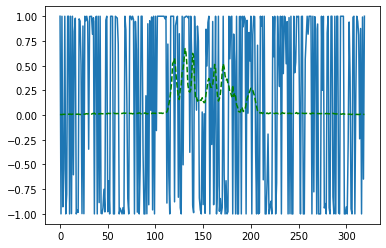

Time taken for epoch:  732.7164945602417
Epoch = [  1/3000]  Iter = [   0/19740]  Loss = 0.8283 Avg Loss = 0.8283  Time = 0.0869s


/opt/conda/lib/python3.6/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch = [  1/3000]  Iter = [10000/19740]  Loss = 0.8635 Avg Loss = 0.8576  Time = 0.0026s
Dev_Loss 0.9650718102073174 Epoch 1
Epoch = [   1/3000] TrainLoss = 0.89  DevLoss = 0.9651 TrainTime = 402.1346s DevTime = 358.4420s


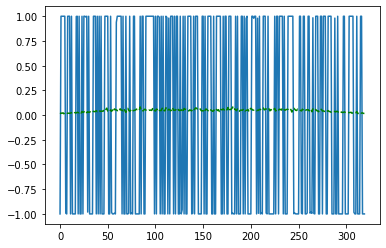

Time taken for epoch:  760.8574409484863
Epoch = [  2/3000]  Iter = [   0/19740]  Loss = 0.9825 Avg Loss = 0.9825  Time = 0.0975s


/opt/conda/lib/python3.6/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


In [ ]:
def train(args): 
    args.exp_dir.mkdir(parents=True, exist_ok=True)
    writer = SummaryWriter(logdir=str(args.logdir)) #log directory for run

    if args.resume: #be aware of the option
        checkpoint, model, optimizer = load_model(args.checkpoint,args)
        args = checkpoint['args']
        best_dev_loss = checkpoint['best_dev_loss']
        #start_epoch = checkpoint['epoch']
        start_epoch = 0
        del checkpoint
    else:
        model = build_model(args)
        optimizer = build_optim(args, model.parameters())
        best_dev_loss = 1e9
        start_epoch = 0
    logging.info(args)
    logging.info(model)

    #train_loader,dev_loader,test_loader = create_data_loaders()
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, args.lr_step_size, args.lr_gamma)
    optimizer.step()

    for epoch in range(start_epoch, args.num_epochs):
        ti=time.time()
        scheduler.step(epoch)
        train_loss, train_time = train_epoch(args, epoch, model, train_loader, optimizer, writer)
        dev_loss, dev_time = evaluate(args, epoch, model, dev_loader, writer)
        #visualize(args, epoch, model, train_loader, writer)

        is_new_best = dev_loss < best_dev_loss
        best_dev_loss = min(best_dev_loss, dev_loss)
        save_model(args, args.exp_dir, epoch, model, optimizer, best_dev_loss, is_new_best)
        print(f'Epoch = [{epoch:4d}/{args.num_epochs:4d}] TrainLoss = {train_loss:.4g} ',
        f'DevLoss = {dev_loss:.4g} TrainTime = {train_time:.4f}s DevTime = {dev_time:.4f}s')
        
        for iter, data in enumerate(train_loader):
            f, t = data
            input = f.unsqueeze(1).to(f'{args.device}:{model.device_ids[0]}')
            target = t.to(f'{args.device}:{model.device_ids[0]}')
            output = model(input).squeeze(1)
            image=output.to('cpu').squeeze(1).detach().numpy()
            plt.plot(range(t[0].shape[0]),image[0].flatten())
            plt.plot(range(t[0].shape[0]),t[0],color="green",linestyle="dashed")
            plt.show()
            break;
        
        logging.info(
            f'Epoch = [{epoch:4d}/{args.num_epochs:4d}] TrainLoss = {train_loss:.4g} '
            f'DevLoss = {dev_loss:.4g} TrainTime = {train_time:.4f}s DevTime = {dev_time:.4f}s',
        )
        print("Time taken for epoch: ",time.time()-ti)
    writer.close()
    return dev_loss
    
train(args)

In [ ]:
run_model(lr):
    args.lr=lr
    return train(args)

In [ ]:
from hyperopt import hp, tpe, fmin

# Single line bayesian optimization of polynomial function
args.num_epochs=100
best = fmin(fn=lambda x: run_model(x),
            space=hp.normal('x', 0.0001, 0.5),
            algo=tpe.suggest,
            max_evals=1000)